In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import keras
from keras.layers import Dense, Activation,BatchNormalization,Input
import numpy as np

C:\Users\sheyda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sheyda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sheyda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sheyda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [2]:
class BufferMemory():
    def __init__(self, max_size=100, batch_size=5):
        self.max = max_size  # maximum number of experiences in buffer
        self.batch = batch_size 
        self.min = batch_size  # minimum number of experiences for training
        self.mem_counter = 0  # index of the last memory saved
        self.buffer = [] #buffer is empty
    
    # append new experience to the buffer, remove the oldest experience if buffer is full
    def append(self, state, action, reward, next_state, terminal):
        if len(self.buffer) == self.max:
            del self.buffer[0]
            self.mem_counter -= 1
        self.buffer.append([state, action, reward, next_state,terminal])

    # select experiences to train online network 
    def sample(self):
        max_mem = min(self.mem_counter, self.min)
        indxs = np.random.choice(max_mem, size =self.batch,replace=False)
        return list(map(self.buffer.__getitem__, indxs))

    def size(self):
        return len(self.buffer)

In [3]:
class Model():
    """
    state_dim - list: dimension of the states (number of elements considered) 
    num_hidden_units - lis: each element of the list is number of neurons in layer and len(list)= number of layers
    layer_sizes: total number of layers including input, hidden, and output layers
    """
    def __init__(self, state_dim,num_hidden_units,num_actions):
        self.state_dim = state_dim
        self.num_hidden_units = num_hidden_units
        self.num_actions = num_actions
        self.layer_sizes = [self.state_dim, self.num_hidden_units, self.num_actions]
        self.create_initializer()

    def create_initializer(self):
        # set seed
        self.initializer =keras.initializers.RandomNormal(seed=100)

    def build_nn(self):
        ########## Create Neural Network: output is the model of neural network #############
        model = keras.Sequential()
        # input layer
        model.add(Dense(units=self.layer_sizes[0],input_shape=(self.state_dim,),kernel_initializer=self.initializer))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        # hidden layers
        for i in np.arange(len(self.num_hidden_units)):
            model.add(Dense(units=self.layer_sizes[1][i],kernel_initializer=self.initializer))
            model.add(Activation('relu'))
        # output layer
        model.add(Dense(units=self.layer_sizes[-1],activation='sigmoid'))
        model.compile(loss='mse', optimizer='adam')
        return model

    def predict_q(self,states, nn):
        """
        Predict action:
        states: input states for prediction
        nn: neural network
        """
        return nn.predict(states)

Using TensorFlow backend.
C:\Users\sheyda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sheyda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sheyda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sheyda\anaconda3\lib\site-packages\tensorflow\python\framework\dtype

In [ ]:
import  numpy as np
import multiprocessing as mp
from scipy.optimize import minimize

class Agent(object):
    def __init__(self,target_net_update_freq,number_of_tasks,
                       discount_factor,action_space,model,batch_size,epsilon,min_epsilon,epsilon_decrease,update_target):
        """
        input aurguments:
        target_net_update_freq: the frequency of updating target network
        number_of_tasks: number of tasks to be processed
        discount_factor: discount factor for reinforcement learning
        action_space: possible actions to select from
        batch_size: batche size for training neural netowork
        epsilon: stochastic gradient learning rate
        min_epsilon: min value of epsilon (no decrease after this value is reached)
        """
        #Network and memory parameters
        self.batch_size=batch_size
        self.buffer = BufferMemory(batch_size=batch_size)
        self.online_net = model.build_nn()
        self.target_net = model.build_nn()
        self.target_update_freq=target_net_update_freq
        self.discount_factor=discount_factor
        self.epsilon_decrease=epsilon_decrease

        # policy parameters
        self.action_space = action_space
        self.num_actions= len(action_space)
        self.state_size=5 # state= [remaining tasks, task size, cpu cycle requirement, path-gain, qos requirement]
        self.update_target = update_target
        self.min_epsilon=min_epsilon
        self.initial_epsilon=epsilon

        # wireless network parameter
        self.power = 0
        self.psi=5 # the delay of mec to cloud (ms)
        self.cpu_cycle =5e5
        self.mec_cpu=100*self.cpu_cycle
        self.cloud_cpu=self.cpu_cycle*1e5
        self.E_trans_max = 0.25
        self.nu=1e-8# energy consumption factor for local: nu*(f_l)^3
        self.noise=1e-9
        self.bandwidth=20*1e3
        self.energy_weight=10

        # tasks parameters
        self.task_q_size=number_of_tasks
        self.number_of_tasks=number_of_tasks # how many tasks are in the task queue
        self.reset()

    def reset(self):
        """
        reset the environment: taks sizes, their cpu demand, and QoS requirement would be reset as well as counters
        """
        self.counter=0
        self.number_of_tasks=self.task_q_size
        self.get_pathgain()
        self.update_target_net()
        self.epsilon=self.initial_epsilon
        self.steps = 1
        self.task_size = np.random.choice([4000,10000,12000,14000,15000,20000,30000,50000,60000,70000],self.number_of_tasks ) # 10k,12k,14k
        self.cpu_needed=np.random.choice([10,20,25,30,35,40,45,60,70,80],self.number_of_tasks)
        self.QoS=np.random.choice([20,30,50,80],self.number_of_tasks)
        #agent parameters
        self.action=[]
        self.total_reward=0
        self.counter=0 #number of tasks that remains to be processed
        self.state= (self.number_of_tasks,self.task_size[self.counter],self.cpu_needed[self.counter],self.path_gain,self.QoS[self.counter]) #initial state

    def get_pathgain(self, radius=150, mec_position=150): # pathgain
        """
        input:
        radius: radius of the cell
        mec_position: where mobile edge cloud is located in the cell
        output:
        returns path-gain of user
        """
        x = np.random.randn() * radius
        y = np.random.randn() * radius
        self.dist = np.sqrt((x - mec_position) ** 2 + (y - mec_position) ** 2)
        # self.path_gain = 34 + 40 * np.log(self.dist / 1000)
        self.path_gain= 8*(self.dist)**-2
#         if 0.8<self.path_gain<=0.9: self.path_gain=0.4
#         elif 0.7<self.path_gain<=0.8: self.path_gain=0.3
#         elif 0.6<self.path_gain<=0.7: self.path_gain=0.2
#         elif 0.5<self.path_gain<=0.6: self.path_gain=0.1
#         elif 0.4<self.path_gain<=0.5: self.path_gain=0.01
#         elif 0.3<self.path_gain<=0.4: self.path_gain=0.001
#         elif 0.2<self.path_gain<=0.3: self.path_gain=0.0001
#         elif 0.1<self.path_gain<=0.2: self.path_gain=0.00001
#         else: self.path_gain=0.000001

                

    def update_FD(self,weights):    # update weights of local model with fd weights
        """
        update weights of both online and target network with the weights of global model 
        
        input
        wieghts: weights of global model after aggregation
        """
        self.online_net.model.set_weights(weights)
        self.update_target_net()

    def get_online_weights(self):   # return online network weights
        """
        returns the weights of online neural network
        """
        return self.online_net.model.get_weights()

    def update_target_net(self):
        """
        Updates the weights of target network with those of online network
        """
        self.target_net.model.set_weights(self.online_net.model.get_weights())

    def optimize_local(self):
        """
        optimizes local computation resoruce allocation while considering our constraints
        """
            obj = lambda f: self.task_size[self.counter] * self.cpu_needed[self.counter] / f + self.energy_weight*self.nu * f ** 3
            cons1 = lambda f: (self.task_size[self.counter] * self.cpu_needed[self.counter] / f)-self.QoS[self.counter]
            cons2 = lambda f: f - self.cpu_cycle
            cons3 = lambda f: self.nu * f ** 2 - self.E_trans_max

            constraint1 = {'type': 'ineq', 'fun': cons1}
            constraint2 = {'type': 'ineq', 'fun': cons2}
            constraint3 = {'type': 'ineq', 'fun': cons3}

            cons = [constraint1, constraint2, constraint3]
            initial_value = 2500
            bounds = [(0, self.cpu_cycle)]
            solution = minimize(obj, initial_value, bounds=bounds, constraints=cons)
            return -solution.fun, solution.x,solution.success

    def get_transmission_delay(self,p):
        """
        calculates transmission delay by deviding task size by transmission rate
        """
        #shannon formula for rate calculation
        rate = self.bandwidth*np.log2(1 + p * self.path_gain / self.noise)
        self.trans_delay= self.task_size[self.counter] / rate


    def objective_mec(self,p):
        """
        calculate transmission delay and energy consumption when mobil edge computing is selected
        
        input
        p: transmit power vector
        """
        self.get_transmission_delay(p)
        self.compu_delay = self.task_size[self.counter] * self.cpu_needed[self.counter] / self.mec_cpu
        energy = p * self.trans_delay
        return self.trans_delay + self.compu_delay + self.energy_weight*energy


    def optimize_mec(self):
        """
        optimize transmit power for minimizing joint energy and delay while considering constraints when mobile edge computing
        is selected
        """
        cons1 = lambda p: p - self.E_trans_max
        cons2 = lambda p: self.task_size[self.counter] / np.log2(1 + p * self.path_gain / self.noise) +\
            self.task_size[self.counter] * self.cpu_needed[self.counter] / self.mec_cpu - self.QoS[self.counter]
        cons = [{'type': 'ineq', 'fun': cons1}, {'type': 'ineq', 'fun': cons2}]
        p0= 0.00002
        #  minimize delay and energy
        solution = minimize(self.objective_mec, p0, constraints=cons, bounds=[(0, self.E_trans_max)])
        return -solution.fun, solution.x,solution.success

    def objective_cloud(self,p):
        """
        calculates delay and energy consumption when cloud computing is selected
        """
        self.get_transmission_delay(p)
        self.compu_delay = self.psi
        energy = p * self.trans_delay
        return self.trans_delay + self.compu_delay+self.energy_weight*energy

    def optimize_cloud(self):
        """
        optimize transmit power for minimizing joint energy and delay while considering constraints when cloud computing 
        is selected
        """
        cons1 = lambda p: p - self.E_trans_max
        cons2 = lambda p: self.task_size[self.counter] / np.log2(1 + p * self.path_gain / self.noise ) + self.psi - self.QoS[self.counter]
        cons = [{'type': 'ineq', 'fun': cons1}, {'type': 'ineq', 'fun': cons2}]
        p0= 0.002 #initial point for transmit power
        solution = minimize(self.objective_cloud, p0, constraints=cons, bounds=[(0, self.E_trans_max)])
        return -solution.fun, solution.x,solution.success

    def get_reward(self,action):
        """
        based on action selected, calculate the immediate reward/cost
        
        input
        action: the selected offlaoding decision 
        
        output:
        immediate reward: weighted summation of delay and energy
        success: if delay<= Quality of service requirement of the task then the process is successfully done, otherwise, it 
        woudl be a failure
        """
        self.trans_delay=0
        self.compu_delay=0
        self.total_delay=0
        immediate_reward=0
        # local computation
        if (action == 0):
            immediate_reward,x,success=self.optimize_local()
            self.total_delay= self.task_size[self.counter] * self.cpu_needed[self.counter] / x
        # MEC computation
        if (action == 1):
            immediate_reward,x,success = self.optimize_mec()
            self.total_delay=self.trans_delay+self.compu_delay
        # Cloud computation
        if (action == 2):
            immediate_reward,x,success=self.optimize_cloud()
            self.total_delay=self.trans_delay+self.compu_delay
            
        self.total_energy_consumption= x*self.trans_delay if action in [1,2] else self.nu * x ** 2
        return immediate_reward,success

    def get_action(self,state):
        """
        randomly selects a eps. if eps<0.5 then randomly choose an action
                                    eps>=0.5 use online network to find the action
        """
        eps=np.random.rand()
        # state=np.resize(state,(self.state_size,1))
        if eps<=self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            s=np.array(state)
            if (s.ndim == 1):
                s = np.array([s])
            q_value=self.online_net.predict(s)
            action=np.argmax(q_value) #get the action with highest possible reward
        return action

    def train_online_net(self):
        """
        train online network
        """
        
        #select experiences --> input data for online network
        experiences= self.buffer.sample()
        states, actions, rewards, next_states,dones = map(list, zip(*experiences))

        next_states=np.array(next_states)
        states=np.array(states)
        rewards=np.array(rewards)

        #### GET TARGET Q VALUE
        q_target_next=self.target_net.predict(next_states)
        q_online_current=self.online_net.predict(states)
        max_actions=np.argmax(q_online_current,axis=1)
        q_target=q_online_current
        batch_index=np.arange(self.batch_size,dtype=np.int32)
        q_target[batch_index,max_actions] = np.reshape(rewards+np.reshape(self.discount_factor*(dones*q_target_next[batch_index,max_actions]),rewards.shape),q_target[batch_index,max_actions].shape)


        ### GET ESTIMATED Q VALUE
        _=self.online_net.fit(states,q_target,verbose=0)
        self.steps += 1

    def get_step(self):
        """
        reinforcement learning steps in each episods
        """
        done=1
        # while there still remains a task to be processed continue
        while(done):
            # get action, reward, check done
            action=self.get_action(self.state)
            reward,success=self.get_reward(action=action)
            
            # if an optimal solution for optimization problem is not found
            if not success: reward,self.total_delay=-10000,10000
                
            # if process of the task is not successful
            if self.total_delay<= self.QoS[self.counter]:
                self.counter += 1
                self.number_of_tasks -= 1
                self.total_reward += self.total_delay+self.energy_weight*self.total_energy_consumption
                if self.epsilon>=self.min_epsilon:
                     self.epsilon *= self.epsilon_decrease
            if self.number_of_tasks<=0: done=0
            if self.number_of_tasks == 0:
                task_size, cpu_needed,QoS =0,0,0
            else:
                task_size=self.task_size[self.counter]
                cpu_needed= self.cpu_needed[self.counter]
                QoS=self.QoS[self.counter]


            ### Add the Exp to the buffer
            new_state=[self.number_of_tasks,task_size,cpu_needed,self.path_gain,QoS] # state= [remaining energy in the battery, remaining tasks in the Q, task size, cpu cycle requirement, path-gain, qos requirement]
            self.buffer.append(self.state,action,reward,new_state,done)
            self.buffer.mem_counter += 1

            if not done: break
            ### Optimize network
            if self.buffer.mem_counter >= self.buffer.min:
                self.train_online_net()
            if self.steps % self.update_target ==0:
                self.update_target_net()






### Network Architecture

In [64]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import multiprocessing as mp

tf.logging.set_verbosity(tf.logging.ERROR)

## Network and memory Args
num_users= 10
local_cpu_cycle= 5e5
memory_size=100
batch_size=30
number_of_tasks=20



## Neural Network
num_hidden_units=[64,16,32,32,16,32,32,16,32,32,16,32,32]


## DRL Args
action_space=np.array((0,1,2))
state_dim=5
num_actions=np.size(action_space)
discount_factor=0.9
target_net_update_freq=3
number_of_episodes=300
users_reward=np.zeros((number_of_episodes,num_users))
users_delay=np.zeros((number_of_episodes,num_users))
users_energy=np.zeros((number_of_episodes,num_users))

epsilon=0.8
min_epsilon= 0.3
epsilon_decrease=0.7
update_target=2

if __name__=='__main__':
    ## Create an object from model: sets input size,output (action) size, hidden layers
    model=Model(state_dim=state_dim,num_hidden_units=num_hidden_units,num_actions=num_actions)
    users=[]
    process=[]

    for i in range(num_users):
        usr=Agent(target_net_update_freq,number_of_tasks,discount_factor,action_space,model,
                  batch_size,epsilon,min_epsilon,epsilon_decrease,update_target)
        users.append(usr)

    for i in range(number_of_episodes):
        print('########## Rount %d of DRL ##########'%(i))
        for j in range(num_users):
            # select a user
            user=users[j]
            # go through RL process
            user.get_step()
            #save current reward, delay and energy consumption
            users_reward[i][j]=user.total_reward
            users_energy[i][j]= user.total_energy_consumption
            users_delay[i][j]=user.total_delay
            #reset environment
            user.reset()
            print('user %d finished'%(j))

        # aggregate local models
        weights = {}
        for j in range(num_users):
            # extract local models' weight
            weights[j] = np.array(users[j].get_online_weights())
        summation = np.zeros(weights[0].shape)
        #calculate average of weights
        for key, value in weights.items():
            summation = summation + value
        Avg = summation / num_users
        for user in users:
            #update the value of local models with those of global model
            user.update_FD(Avg)
    
    #save for future plotting
    reward_batch_30_64_16_32_32_16_32_32_16_32_32_16_32_32=users_reward.sum(axis=1)
    total_energy=users_energy.sum(axis=1)
    total_delay=users_delay.sum(axis=1)


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


########## Rount 0 of DRL ##########


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 0 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launc

user 1 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


user 2 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


user 3 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\she

user 4 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 5 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


user 6 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


user 7 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 8 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 9 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


########## Rount 1 of DRL ##########


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


########## Rount 2 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 3 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 4 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 5 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 6 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Roun

user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 44 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 45 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 46 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 47 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 48 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 fin

user 8 finished
user 9 finished
########## Rount 85 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 86 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 87 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 88 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 89 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 fin

user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 127 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 128 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 129 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 130 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 131 of DRL ##########
user 

user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 168 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 169 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 170 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 171 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 172 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 

user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 209 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 210 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 211 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 212 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 213 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 

user 9 finished
########## Rount 250 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 251 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 252 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 253 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 254 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 

user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 292 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 293 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 294 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 295 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 296 of DRL ##########
user 

In [2]:
## use loadtxt and savetxt commands to save the results of calculations or load them to a variable
reward_30_64_16_32=np.loadtxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\reward_batch_30_64_16_32.csv')
reward_batch_30_64_16_32_32=np.loadtxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\reward_batch_30_64_16_32_32.csv')
reward_batch_30_64_16_32_32_16_32_32_16_32_32=np.loadtxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\reward_batch_30_64_16_32_32_16_32_32_16_32_32.csv')
reward_batch_30_64_16_32_32_16_32_32_16_32_32=np.loadtxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\reward_batch_30_64_16_32_32_16_32_32_16_32_32')
reward_batch_30_64_16_32_32_16_32_32_16_32_32_16_32_32=np.loadtxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\reward_batch_30_64_16_32_32_16_32_32_16_32_32_16_32_32.csv')


## reward for different neural network architecture

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

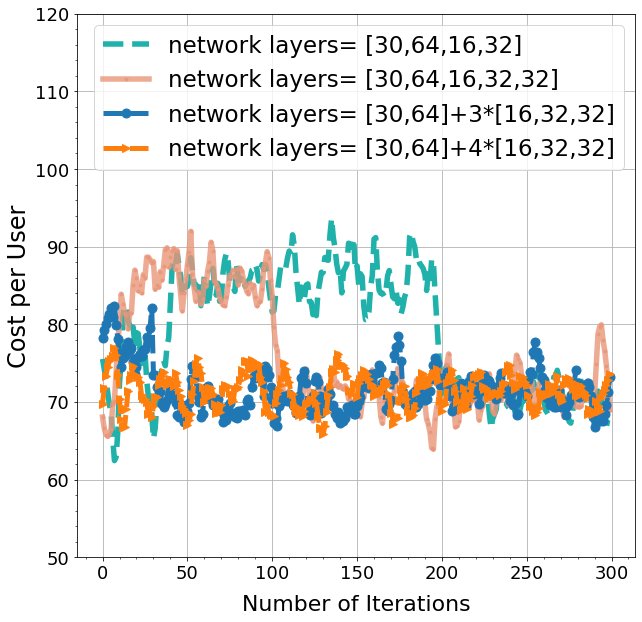

In [18]:
from scipy.signal import savgol_filter
from matplotlib.ticker import AutoMinorLocator
number_of_episodes=300
fig,ax=plt.subplots(1,1,figsize=(10,10))

#smooth results using avgol-filter in scipy
x=savgol_filter(reward_30_64_16_32/10, 9, 2)
y=savgol_filter(reward_batch_30_64_16_32_32/10, 9, 2)
z=savgol_filter(reward_batch_30_64_16_32_32_16_32_32_16_32_32/10,9,2)
z[:30]=z[:30]*1.09
q=savgol_filter(reward_batch_30_64_16_32_32_16_32_32_16_32_32_16_32_32/10,11,2)
ax.plot(np.arange(number_of_episodes),x,'--',ms=6,label='network layers= [30,64,16,32]',linewidth=5.5,c='lightseagreen')
ax.plot(np.arange(number_of_episodes),y,'.-',ms=6,label='network layers= [30,64,16,32,32]',lw=5.5,c='darksalmon',alpha=0.8)
ax.plot(np.arange(number_of_episodes),z,'--o',ms=9,label='network layers= [30,64]+3*[16,32,32]',lw=5)

ax.plot(np.arange(number_of_episodes),q,'-->',ms=8,label='network layers= [30,64]+4*[16,32,32]',lw=5)




ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', labelsize=14,pad=4)

plt.xlabel('Number of Iterations',fontsize='22',labelpad=12)
plt.ylabel('Cost per User',fontsize='24')
plt.legend(loc='upper right',fontsize='23')

plt.ylim(50,120)
plt.grid()

from matplotlib.ticker import AutoMinorLocator
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', labelsize=18,pad=4)
plt.grid('on')

fig.savefig(r'C:\Users\sheyda\Desktop\DDQN\new_fig\net_arch3.eps', format='eps', dpi=2200)
fig.savefig(r'C:\Users\sheyda\Desktop\DDQN\new_fig\net_arch3.svg', format='svg', dpi=2200)
plt.savefig(r'C:\Users\sheyda\Desktop\DDQN\new_fig\net_arch3', dpi=2200)


## reward for differnt values of batch-size

In [82]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import multiprocessing as mp

tf.logging.set_verbosity(tf.logging.ERROR)

## Network and memory Args
num_users= 10
local_cpu_cycle= 5e5
memory_size=100
batch_size=5
number_of_tasks=20



## Neural Network
num_hidden_units=[64,16,32,32,16]


## DRL Args
action_space=np.array((0,1,2))
state_dim=5
num_actions=np.size(action_space)
discount_factor=0.9
target_net_update_freq=3
number_of_episodes=300
users_reward=np.zeros((number_of_episodes,num_users))
users_delay=np.zeros((number_of_episodes,num_users))
users_energy=np.zeros((number_of_episodes,num_users))

epsilon=0.8
min_epsilon= 0.3
epsilon_decrease=0.7
update_target=2

if __name__=='__main__':
    ## Create an object from model: sets input size,output (action) size, hidden layers
    model=Model(state_dim=state_dim,num_hidden_units=num_hidden_units,num_actions=num_actions)
    users=[]
    process=[]

    for i in range(num_users):
        usr=Agent(target_net_update_freq,number_of_tasks,discount_factor,action_space,model,
                  batch_size,epsilon,min_epsilon,epsilon_decrease,update_target)
        users.append(usr)

    for i in range(number_of_episodes):
        print('########## Rount %d of DRL ##########'%(i))
        for j in range(num_users):
            user=users[j]
            user.get_step()
#             print(' user reward:',user.total_reward)
            users_reward[i][j]=user.total_reward
            users_energy[i][j]= user.total_energy_consumption
#             print(' user energy consumption:',user.total_energy_consumption)
            users_delay[i][j]=user.total_delay
#             print(' user delay:',user.total_delay)
            user.reset()
            print('user %d finished'%(j))

        weights = {}
        for j in range(num_users):
            weights[j] = np.array(users[j].get_online_weights())
        summation = np.zeros(weights[0].shape)
        for key, value in weights.items():
            summation = summation + value
        Avg = summation / num_users
        for user in users:
            user.update_FD(Avg)

    reward_batch_5_64_16_32_32_16_32_32_16_32_32=users_reward.sum(axis=1)
    total_energy=users_energy.sum(axis=1)
    total_delay=users_delay.sum(axis=1)


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


########## Rount 0 of DRL ##########


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launc

user 0 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 1 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 2 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 3 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launc

user 4 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 5 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


user 6 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 7 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


user 8 finished


C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 9 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


########## Rount 1 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 2 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 3 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 4 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 5 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Roun

user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 43 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 44 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 45 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 46 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 47 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 fin

user 8 finished
user 9 finished
########## Rount 84 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 85 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 86 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 87 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 88 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 fin

user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 126 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 127 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 128 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 129 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 130 of DRL ##########
user 

user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 167 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 168 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 169 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 170 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 171 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 

user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 208 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 209 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 210 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 211 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 212 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 

user 9 finished
########## Rount 249 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 250 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 251 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 252 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 253 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 

user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 291 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 292 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 293 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 294 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 295 of DRL ##########
user 

### save or load the obtained result

In [72]:
x=reward_batch_5_64_16_32_32_16_32_32_16_32_32[:]
reward_batch_10_64_16_32_32_16_32_32_16_32_32=np.loadtxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\reward_batch_5_64_16_32_32_16_32_32_16_32_32')
reward_batch_20_64_16_32_32_16_32_32_16_32_32=np.loadtxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\reward_batch_10_64_16_32_32_16_32_32_16_32_32')
reward_batch_30_64_16_32_32_16_32_32_16_32_32=np.loadtxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\reward_batch_30_64_16_32_32_16_32_32_16_32_32')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

''

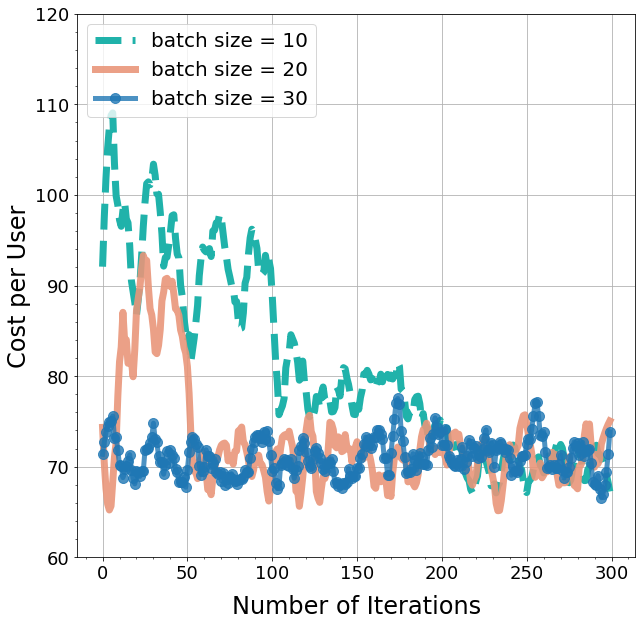

In [77]:
from scipy.signal import savgol_filter
from matplotlib.ticker import AutoMinorLocator


fig,ax=plt.subplots(1,1,figsize=(10,10))
x=savgol_filter(reward_batch_10_64_16_32_32_16_32_32_16_32_32/10, 13, 2)
# y=savgol_filter(reward_batch_30_64_16_32_32/10, 9, 2)
y=savgol_filter(reward_batch_20_64_16_32_32_16_32_32_16_32_32/10, 11, 2)
z=savgol_filter(reward_batch_30_64_16_32_32_16_32_32_16_32_32/10,11,2)
ax.plot(np.arange(number_of_episodes),x,'--',ms=6,label='batch size = 10',linewidth=7,c='lightseagreen')
ax.plot(np.arange(number_of_episodes),y,'-',ms=6,label='batch size = 20',lw=7,c='darksalmon',alpha=0.9)
ax.plot(np.arange(number_of_episodes),z,'-o',ms=10,label='batch size = 30',lw=5,alpha=0.8)



ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', labelsize=14,pad=4)

plt.xlabel('Number of Iterations',fontsize='24',labelpad=12)
plt.ylabel('Cost per User',fontsize='24')
plt.legend(loc='upper left',fontsize='20')

plt.ylim(60,120)
plt.grid()

from matplotlib.ticker import AutoMinorLocator
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', labelsize=18,pad=4)
plt.grid('on')

fig.savefig(r'C:\Users\sheyda\Desktop\DDQN\new_fig\batch_3.eps', format='eps', dpi=2100)
fig.savefig(r'C:\Users\sheyda\Desktop\DDQN\new_fig\batch_3.svg', format='svg', dpi=2100)
plt.savefig(r'C:\Users\sheyda\Desktop\DDQN\new_fig\batch_3', dpi=2100)
;

## Frequency of update

In [9]:
reward_30_64_16_32_32_freq_5=np.loadtxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\frq_5')
reward_30_64_16_32_32_freq_3=np.loadtxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\frq_3')
reward_30_64_16_32_32_freq_1=np.loadtxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\frq_1')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


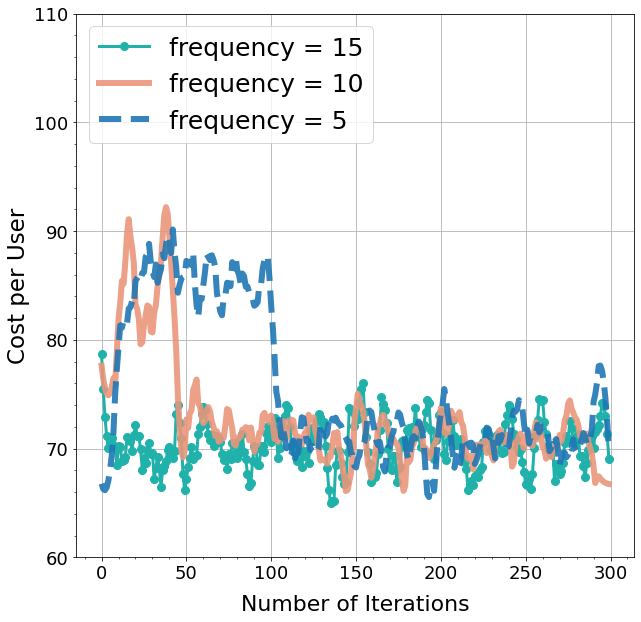

In [70]:
from scipy.signal import savgol_filter
from matplotlib.ticker import AutoMinorLocator
number_of_episodes=300

fig,ax=plt.subplots(1,1,figsize=(10,10))
x=savgol_filter(reward_30_64_16_32_32_freq_5/10, 9, 2)
w=savgol_filter(reward_30_64_16_32_32_freq_3/10, 13, 2)
z=savgol_filter(reward_30_64_16_32_32_freq_1/10, 13, 2)

ax.plot(np.arange(number_of_episodes),x,'-o',ms=8,label='frequency = 15',linewidth=3,c='lightseagreen')
ax.plot(np.arange(number_of_episodes),w,'-',label='frequency = 10',lw=6,c='darksalmon',alpha=0.9)
ax.plot(np.arange(number_of_episodes),z,'--',ms=9,label='frequency = 5',lw=6,alpha=0.9)




ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', labelsize=14,pad=4)

plt.xlabel('Number of Iterations',fontsize='22',labelpad=12)
plt.ylabel('Cost per User',fontsize='23')
plt.legend(loc='upper left',fontsize='25')

plt.ylim(60,110)
plt.grid()

from matplotlib.ticker import AutoMinorLocator
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', labelsize=18,pad=4)
plt.grid('on')

fig.savefig(r'C:\Users\sheyda\Desktop\DDQN\new_fig\freq3.eps', format='eps', dpi=2100)
fig.savefig(r'C:\Users\sheyda\Desktop\DDQN\new_fig\freq3.svg', format='svg', dpi=2100)
plt.savefig(r'C:\Users\sheyda\Desktop\DDQN\new_fig\freq3', dpi=2100)


## Exploration rate

In [438]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import multiprocessing as mp

tf.logging.set_verbosity(tf.logging.ERROR)

## Network and memory Args
num_users= 10
local_cpu_cycle= 5e5
memory_size=100
batch_size=20
number_of_tasks=20


## Neural Network
num_hidden_units=[30,64,16,32,32]


## DRL Args
action_space=np.array((0,1,2))
state_dim=5
num_actions=np.size(action_space)
discount_factor=0.9
target_net_update_freq=5
number_of_episodes=300
users_reward=np.zeros((number_of_episodes,num_users))
users_delay=np.zeros((number_of_episodes,num_users))
users_energy=np.zeros((number_of_episodes,num_users))

epsilon=0.3 #ghabli: 0.8
min_epsilon= 0.3
epsilon_decrease=0.7
update_target=3

if __name__=='__main__':
    ## Create an object from model: sets input size,output (action) size, hidden layers
    model=Model(state_dim=state_dim,num_hidden_units=num_hidden_units,num_actions=num_actions)
    users=[]
    process=[]

    for i in range(num_users):
        usr=Agent(target_net_update_freq,number_of_tasks,discount_factor,action_space,model,
                  batch_size,epsilon,min_epsilon,epsilon_decrease,update_target)
        users.append(usr)

    for i in range(number_of_episodes):
        print('########## Rount %d of DRL ##########'%(i))
        for j in range(num_users):
            user=users[j]
            user.get_step()
#             print(' user reward:',user.total_reward)
            users_reward[i][j]=user.total_reward
            users_energy[i][j]= user.total_energy_consumption
#             print(' user energy consumption:',user.total_energy_consumption)
            users_delay[i][j]=user.total_delay
#             print(' user delay:',user.total_delay)
            user.reset()
            print('user %d finished'%(j))

        weights = {}
        for j in range(num_users):
            weights[j] = np.array(users[j].get_online_weights())
        summation = np.zeros(weights[0].shape)
        for key, value in weights.items():
            summation = summation + value
        Avg = summation / num_users
        for user in users:
            user.update_FD(Avg)

    reward_30_64_16_32_32_epsilon_03=users_reward.sum(axis=1)
    total_energy_epsilon_03=users_energy.sum(axis=1)
    total_delay_freq_epsilon_03=users_delay.sum(axis=1)


########## Rount 0 of DRL ##########


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

user 0 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


user 1 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 2 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 3 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 4 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


user 5 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\she

user 6 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


user 7 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\sheyda\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


user 8 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shap

user 9 finished


C:\Users\sheyda\anaconda3\lib\site-packages\ipykernel_launcher.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


########## Rount 1 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 2 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 3 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 4 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 5 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Roun

user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 43 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 44 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 45 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 46 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 47 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 fin

user 8 finished
user 9 finished
########## Rount 84 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 85 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 86 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 87 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 88 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 fin

user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 126 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 127 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 128 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 129 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 130 of DRL ##########
user 

user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 167 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 168 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 169 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 170 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 171 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 

user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 208 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 209 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 210 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 211 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 212 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 

user 9 finished
########## Rount 249 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 250 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 251 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 252 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 253 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 

user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 291 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 292 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 293 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 294 of DRL ##########
user 0 finished
user 1 finished
user 2 finished
user 3 finished
user 4 finished
user 5 finished
user 6 finished
user 7 finished
user 8 finished
user 9 finished
########## Rount 295 of DRL ##########
user 

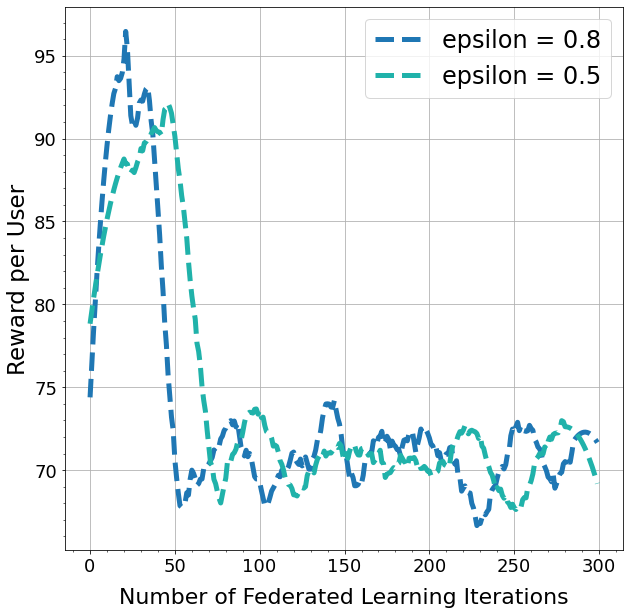

In [513]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
x=savgol_filter(reward_30_64_16_32_32_epsilon_08/10, 29, 2)
y=savgol_filter(reward_30_64_16_32_32_epsilon_05/10, 39, 2)
# z=savgol_filter(reward_30_64_16_32_32_freq_1/10, 9, 2)

ax.plot(np.arange(number_of_episodes),x,'--',ms=6,label='epsilon = 0.8',linewidth=5)
ax.plot(np.arange(number_of_episodes),y,'--',ms=6,label='epsilon = 0.5',linewidth=5,c='lightseagreen')





ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', labelsize=14,pad=4)

plt.xlabel('Number of Federated Learning Iterations',fontsize='22',labelpad=12)
plt.ylabel('Reward per User',fontsize='23')
plt.legend(loc='upper right',fontsize='24')

plt.grid()

from matplotlib.ticker import AutoMinorLocator
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', labelsize=18,pad=4)
plt.grid('on')


## Comparison

In [514]:
reward_30_64_16_32_32_epsilon_05=np.loadtxt(r'C:\Users\sheyda\Desktop\mrs.khoramnejad\DDQN\new_data_set\epsilon05')
reward_30_64_16_32_32_epsilon_08=np.loadetxt(r'C:\Users\sheyda\Desktop\mrs.khoramnejad\DDQN\new_data_set\epsilon08')
np.savetxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\delay_epsilon05',total_energy_epsilon_05)
np.savetxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\energy_epsilon05',total_delay_freq_epsilon_05)
np.savetxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\delay_epsilon05',total_energy_epsilon_08)
np.savetxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\energy_epsilon05',total_delay_freq_epsilon_08)

In [11]:
reward_30_64_16_32_32_freq_5_here=np.loadtxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\reward_30_64_16_32_32_freq_5_here')

In [12]:
center=np.loadtxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\center')
freq_1=np.loadtxt(r'C:\Users\sheyda\Desktop\DDQN\new_data_set\frq_1')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

''

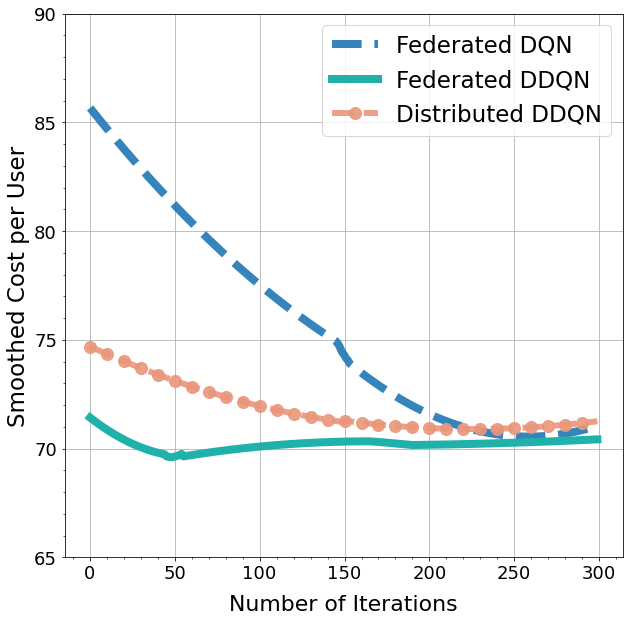

In [69]:
from scipy.signal import savgol_filter
from matplotlib.ticker import AutoMinorLocator


fig,ax=plt.subplots(1,1,figsize=(10,10))
# x=savgol_filter(reward_30_64_16_32_32_freq_5_here/10, 101, 2)
# # x[:50]=x[:50]*1.009
# # x[:60]=x[:60]*1.004
# # x[:60]=x[:60]*1.004

# x[45:55]=savgol_filter(x[45:55], 9, 2)*0.9989
# x[55:]=savgol_filter(x[55:], 221, 2)*0.997
x=reward_30_64_16_32_32_freq_5_here
y=savgol_filter(center/10, 299, 2)
z=savgol_filter(freq_1/10, 291, 2)



markers_on=list(range(0,300,10))
markers_on1=list(range(0,300,12))


ax.plot(np.arange(number_of_episodes),z,'--',ms=15,label='Federated DQN',lw=8,alpha=0.9,markevery=markers_on1)
ax.plot(np.arange(number_of_episodes),x,'-',ms=12,label='Federated DDQN',linewidth=8,c='lightseagreen')
ax.plot(np.arange(number_of_episodes),y,'--o',ms=12,label='Distributed DDQN',lw=6,c='darksalmon',alpha=0.9,markevery=markers_on)




ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', labelsize=14,pad=4)

plt.xlabel('Number of Iterations',fontsize='22',labelpad=12)
plt.ylabel('Smoothed Cost per User',fontsize='23')
plt.legend(loc='upper right',fontsize='23')

plt.ylim(65,90)
plt.grid()

from matplotlib.ticker import AutoMinorLocator
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', labelsize=18,pad=4)
plt.grid('on')

fig.savefig(r'C:\Users\sheyda\Desktop\DDQN\new_fig\compare_with_center3.eps', format='eps', dpi=2100)
fig.savefig(r'C:\Users\sheyda\Desktop\DDQN\new_fig\compare_with_center3.svg', format='svg', dpi=2100)
plt.savefig(r'C:\Users\sheyda\Desktop\DDQN\new_fig\compare_with_center3', dpi=1800)
;